## Projeto 4 Redes Complexas
    Fernando Soares de Aguiar Neto  (7152184)
    Guiherme Guilherme Milan Santos (9012966)


### Imports e Funções

In [10]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import random
import math
from networkx.algorithms.community.community_generators import LFR_benchmark_graph

In [2]:
def printInfo(graph):
    N = len(graph)
    M = graph.number_of_edges()
    print('Nós:', N)
    print('Arestas:', M)
    print('Grau Médio:', 2*M/N)

def set_ax_fontsize(ax, fontsize):
    ax.title.set_fontsize(fontsize)
    ax.xaxis.label.set_fontsize(fontsize)
    ax.yaxis.label.set_fontsize(fontsize)
    [tick.set_fontsize(fontsize) for tick in ax.get_xticklabels()];
    [tick.set_fontsize(fontsize) for tick in ax.get_yticklabels()];

def failures(H):
    G = H.copy()
    
    N0 = len(G)
    vn = [] #percentage of removed nodes
    S = []
    n = 0 #number of nodes removed
    while(len(G.nodes()) > int(0.01*N0)):
        #print('Removing... n = ', n)
        #print(G.nodes)
        node = random.choice(list(G.nodes())) #select the node on the largest component
        #print('selected to removed:', node)
        G.remove_node(node) 
        Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
        Glc=Gcc[0] 
        S.append(len(Glc)/N0) #store the size of the largest component
        n = n + 1
        vn.append(n/N0)
    return S, vn

    
def most_connected(G): # This function is used to find the most connected node
    maxk = 0
    node = 0
    for i in G.nodes():
        if(G.degree(i) >= maxk):
            maxk = G.degree(i)
            node = i
    return node 

def attacks(H):
    G = H.copy()
    from random import choice
    N0 = len(G)
    vn = []
    S = []
    n = 0 #number of nodes removed
    while(len(G.nodes()) > int(0.01*N0)):
        #print('Removing... n = ', n)
        #print(G.nodes)
        node = most_connected(G) #select the most connected node on the largest component            
        #print('selected to removed:', node)
        G.remove_node(node) 
        Gcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
        Glc=Gcc[0] 
        S.append(len(Glc)/N0) #store the size of the largest component
        n = n + 1
        vn.append(n/N0)
    return S, vn

def momment_of_degree_distribution2(G,m):
        M = 0
        N = len(G)
        for i in G.nodes():
            M = M + G.degree(i)**m
        M = M/N
        return M

def fcritical(G):
    f = 1 - 1/(momment_of_degree_distribution2(G,2)/momment_of_degree_distribution2(G,1) - 1)
    return f


## Exercício 1

In [3]:
rep = 15
largeCompSizeFailure = dict()
largeCompSizeAttack = dict()
fc =  dict()
percentil = dict()
av_degree = 10
n = 350
p = av_degree/(n-1)


#ER
er = nx.gnp_random_graph(n=n, p=p, seed=None, directed=False)
s, vn = failures(er)
size = len(vn)

S = np.zeros(size)
Atq = np.zeros(size)
p = av_degree/(n-1)
fc['ER'] = 0
for i in range(rep):
    er = nx.gnp_random_graph(n=n, p=p, seed=None, directed=False)
    s, vn = failures(er)
    S = S + s
    atq, vn = attacks(er)
    Atq = Atq + atq
    Fc = fcritical(er)
    fc['ER'] = fc['ER'] + Fc
    
fc['ER'] = fc['ER']/rep    
largeCompSizeFailure['ER'] = S/rep#np.mean(S, axis=0)
largeCompSizeAttack['ER'] = Atq/rep
percentil['ER'] = vn

#BA
fc['BA'] = 0
S = np.zeros(size)
Atq = np.zeros(size)
m = int(av_degree/2)
for i in range(rep):
    ba = nx.barabasi_albert_graph(n, m)
    s, vn = failures(ba)
    S = S + s
    atq, vn = attacks(ba)
    Atq = Atq + atq
    Fc = fcritical(ba)
    fc['BA'] = fc['BA'] + Fc
    
fc['BA'] = fc['BA']/rep  
largeCompSizeFailure['BA'] = S/rep
largeCompSizeAttack['BA'] = Atq/rep
percentil['BA'] = vn

#SW 10E-3
fc['SW10E-3'] = 0
S = np.zeros(size)
Atq = np.zeros(size)
p = 0.001 #probability of rewiring
for i in range(rep):
    sw = nx.watts_strogatz_graph(n, av_degree, p, seed=None)
    s, vn = failures(sw)
    S = S + s
    atq, vn = attacks(sw)
    Atq = Atq + atq
    Fc = fcritical(sw)
    fc['SW10E-3'] = fc['SW10E-3'] + Fc
    
fc['SW10E-3'] = fc['SW10E-3']/rep         
largeCompSizeFailure['SW10E-3'] = S/rep
largeCompSizeAttack['SW10E-3'] = Atq/rep
percentil['SW10E-3'] = vn

#SW 10E-2
fc['SW10E-2'] = 0
S = np.zeros(size)
Atq = np.zeros(size)
p = 0.01 #probability of rewiring
for i in range(rep):
    sw = nx.watts_strogatz_graph(n, av_degree, p, seed=None)
    s, vn = failures(sw)
    S = S + s
    atq, vn = attacks(sw)
    Atq = Atq + atq
    Fc = fcritical(sw)
    fc['SW10E-2'] = fc['SW10E-2'] + Fc
    
fc['SW10E-2'] = fc['SW10E-2']/rep     
largeCompSizeFailure['SW10E-2'] = S/rep
largeCompSizeAttack['SW10E-2'] = Atq/rep
percentil['SW10E-2'] = vn

#SW 10E-1
fc['SW10E-1'] = 0
S = np.zeros(size)
Atq = np.zeros(size)
p = 0.1 #probability of rewiring
for i in range(rep):
    sw = nx.watts_strogatz_graph(n, av_degree, p, seed=None)
    s, vn = failures(sw)
    S = S + s
    atq, vn = attacks(sw)
    Atq = Atq + atq
    Fc = fcritical(sw)
    fc['SW10E-1'] = fc['SW10E-1'] + Fc
    
fc['SW10E-1'] = fc['SW10E-1']/rep 
largeCompSizeFailure['SW10E-1'] = S/rep
largeCompSizeAttack['SW10E-1'] = Atq/rep
percentil['SW10E-1'] = vn

#Regular WS
fc['WS1'] = 0
S = np.zeros(size)
Atq = np.zeros(size)
p = 0 #probability of rewiring
for i in range(rep):
    sw = nx.watts_strogatz_graph(n, av_degree, p, seed=None)
    s, vn = failures(sw)
    S = S + s
    atq, vn = attacks(sw)
    Atq = Atq + atq
    Fc = fcritical(sw)
    fc['WS1'] = fc['WS1'] + Fc
    
fc['WS1'] = fc['WS1']/rep 
largeCompSizeFailure['WS1'] = S/rep
largeCompSizeAttack['WS1'] = Atq/rep
percentil['WS1'] = vn

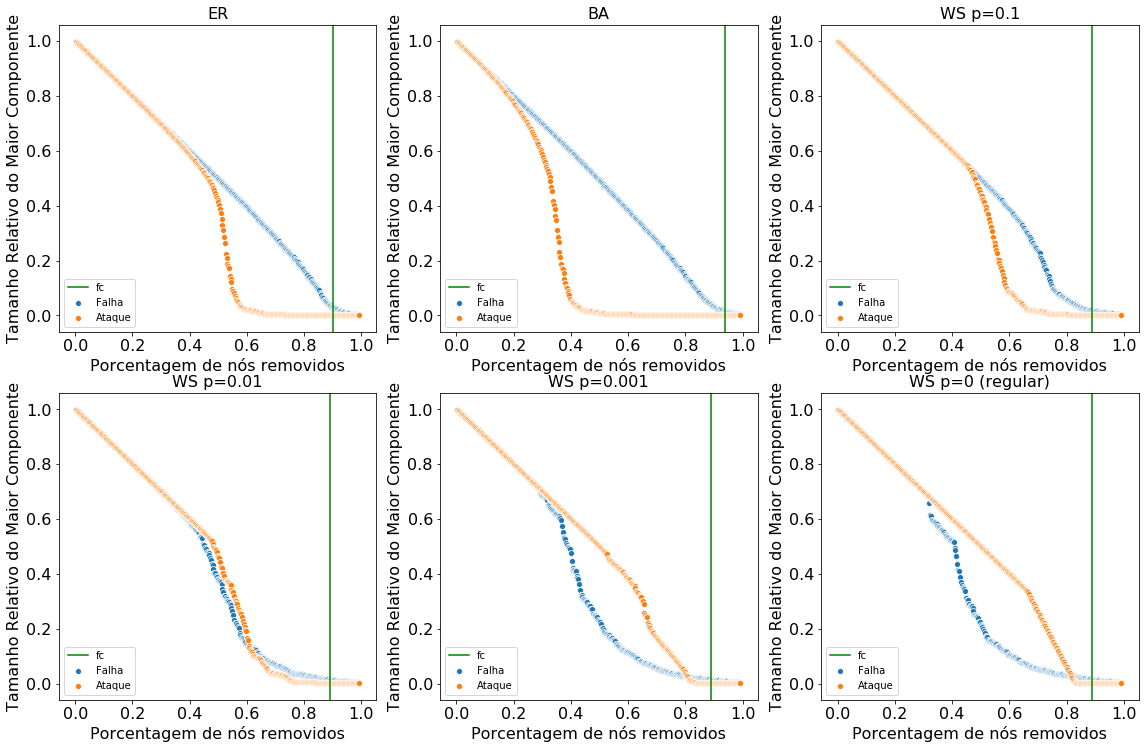

In [4]:
fig, axis = plt.subplots(2,3, figsize=(8,5))
l,c = 0,0
n = 0
for rede, title in [('ER','ER'),('BA','BA'),('SW10E-1','WS p=0.1'),('SW10E-2','WS p=0.01'),('SW10E-3','WS p=0.001'),('WS1','WS p=0 (regular)')]:

    plt.subplots_adjust(right=2, top=2)
    axis[l,c].set_xlabel('Porcentagem de nós removidos')
    axis[l,c].set_ylabel('Tamanho Relativo do Maior Componente')
    axis[l,c].set_title(title)
    set_ax_fontsize(axis[l,c], 16)
    axis[l,c].axvline(x=fc[rede], color = 'g', label='fc')
    sns.scatterplot(x=percentil[rede], y=largeCompSizeFailure[rede], ax=axis[l,c], label='Falha')
    sns.scatterplot(x=percentil[rede], y=largeCompSizeAttack[rede], ax=axis[l,c], label='Ataque')
    n = n+1
    l = math.floor(n/3)
    c = (n) % 3

Utilizamos a média de 15 repetições das redes.
Notamos que as redes smal world, tendem a ser mais robustas, tanto a ataques quanto falhas, provavelmente dada a complexidade da sua estrutura. Por sua vez redes livres de escala, ainda que sejam resilientes a falhas, são muito suscetíveis a ataques direcionados, uma vez que os hubs acabam sendo responsáveis por ligar diversas 'regiões' da rede. Por fim, as redes ER apresentam resiliencia maior a ataques em comparação com as BA, devido a não existir prioridades na escolha de novas arestas, desfavorecendo a criação de hubs.

## Para redes reais.

In [5]:
#Human Protein
protein = nx.read_edgelist("../datasets/out.maayan-vidal", comments='%')
protein = max(nx.connected_component_subgraphs(protein), key=len)
protein = protein.to_undirected()
protein.remove_edges_from(nx.selfloop_edges(protein))
protein = nx.convert_node_labels_to_integers(protein, first_label=0)
print("\n\nHuman Protein")
printInfo(protein)

# c-elegans 2007
celegans2007 = nx.read_edgelist('../datasets/C-elegans-2007.txt')
celegans2007 = celegans2007.to_undirected()
celegans2007.remove_edges_from(nx.selfloop_edges(celegans2007))
celegans2007 = max(nx.connected_component_subgraphs(celegans2007), key=len)
celegans2007 = nx.convert_node_labels_to_integers(celegans2007, first_label=0)
print("\n\nC-Elegans 2007")
printInfo(celegans2007)

#mosquito
mosquito = nx.read_edgelist('../datasets/mosquito.csv')
mosquito = mosquito.to_undirected()
mosquito = max(nx.connected_component_subgraphs(mosquito), key=len)
mosquito = nx.convert_node_labels_to_integers(mosquito, first_label=0)
print("\n\nMosquito")
printInfo(mosquito)




Human Protein
Nós: 2783
Arestas: 6007
Grau Médio: 4.316924182536831


C-Elegans 2007
Nós: 1108
Arestas: 1500
Grau Médio: 2.707581227436823


Mosquito
Nós: 6162
Arestas: 64380
Grau Médio: 20.895813047711783


In [6]:
fc = dict()
failure = dict()
attack = dict()
percentil = dict()

#protein
failure['protein'], percentil['protein'] = failures(protein)
attack['protein'], percentil['protein'] = attacks(protein)
fc['protein'] = fcritical(protein)

# c-elegans 2007
failure['celegans'], percentil['celegans'] = failures(celegans2007)
attack['celegans'], percentil['celegans'] = attacks(celegans2007)
fc['celegans'] = fcritical(celegans2007)

#mosquito
fc['mosquito'] = 0
failure['mosquito'], percentil['mosquito'] = failures(mosquito)
attack['mosquito'], percentil['mosquito'] = attacks(mosquito)
fc['mosquito'] = fcritical(mosquito)

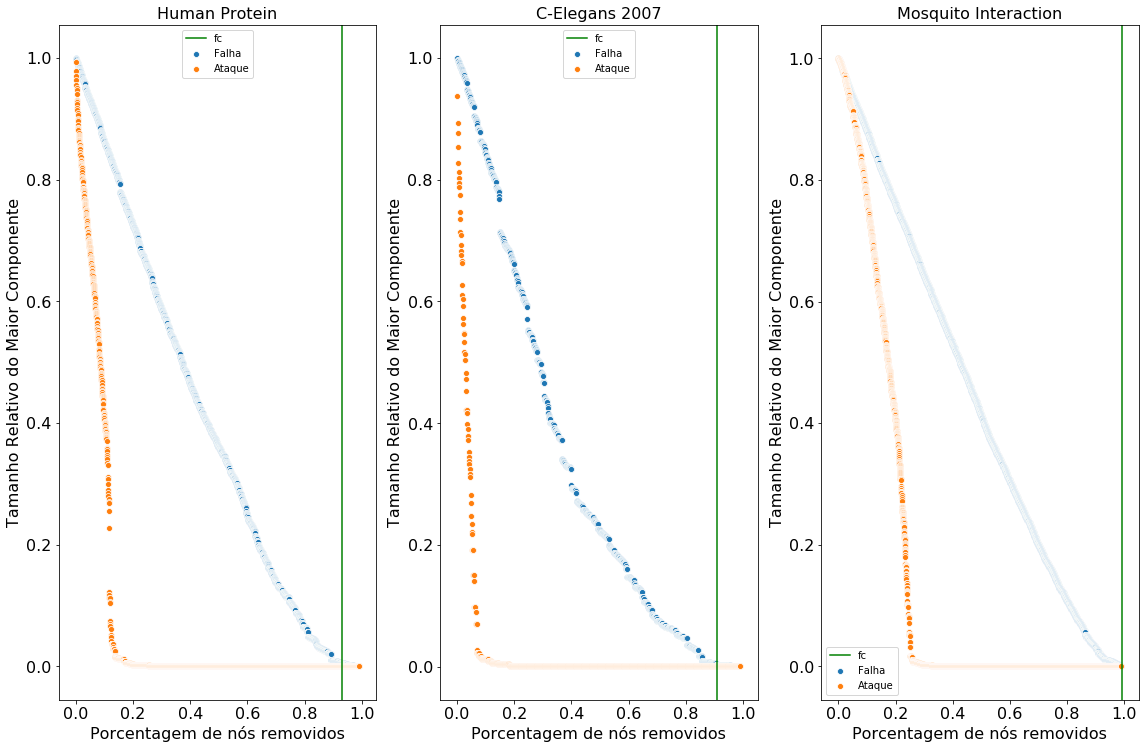

In [8]:
fig, axis = plt.subplots(1,3, figsize=(8,5))
n = 0
for rede, title in [('protein','Human Protein'),('celegans','C-Elegans 2007'),('mosquito','Mosquito Interaction')]:

    plt.subplots_adjust(right=2, top=2)
    axis[n].set_xlabel('Porcentagem de nós removidos')
    axis[n].set_ylabel('Tamanho Relativo do Maior Componente')
    axis[n].set_title(title)
    set_ax_fontsize(axis[n], 16)
    axis[n].axvline(x=fc[rede], color = 'g', label='fc')
    sns.scatterplot(x=percentil[rede], y=failure[rede], ax=axis[n], label='Falha')
    sns.scatterplot(x=percentil[rede], y=attack[rede], ax=axis[n], label='Ataque')
    n = n+1


As três redes apresentam uma baixa resistência a ataques, provavelmente devido a serem livres de escala. Entre elas, a rede de interação de mosquitos é a que apresenta maior resistência a ataques, precisando de pouco mais de 20% dos nós removidos via ataques para quebrar completamente.

## Efeito de Comunidade

In [13]:
N = 128
tau1 = 3
tau2 = 1.5
k =16
minc = 16
maxc = 16

rep = 15
largeCompSizeFailure = dict()
largeCompSizeAttack = dict()
fc =  dict()
percentil = dict()

#getting vn size
G = LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = 0.1, min_degree = k, 
                        max_degree = k, min_community=minc, max_community = maxc)
s, vn = failures(G)
size = len(vn)

#Mu = 0.1
for mu in [0.1, 0.3, 0.5]:
    fc[mu] = 0
    S = np.zeros(size)
    Atq = np.zeros(size)
    for i in range(rep):
        G = LFR_benchmark_graph(n = N, tau1 = tau1, tau2 = tau2, mu = mu, min_degree = k, 
                            max_degree = k, min_community=minc, max_community = maxc)
        s, vn = failures(G)
        S = S + s
        atq, vn = attacks(G)
        Atq = Atq + atq
        Fc = fcritical(G)
        fc[mu] = fc[mu]+ Fc

    fc[mu] = fc[mu]/rep 
    largeCompSizeFailure[mu] = S/rep
    largeCompSizeAttack[mu] = Atq/rep
    percentil[mu] = vn

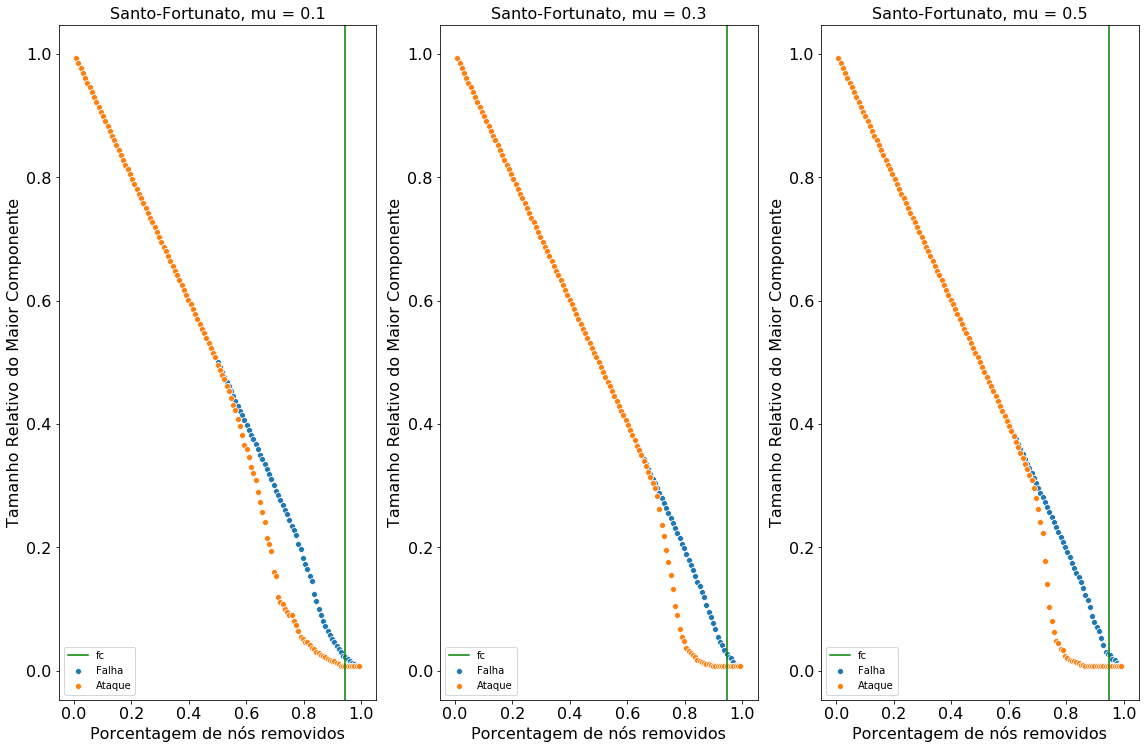

In [17]:
fig, axis = plt.subplots(1,3, figsize=(8,5))
n = 0
for mu in [0.1, 0.3, 0.5]:
    plt.subplots_adjust(right=2, top=2)
    axis[n].set_xlabel('Porcentagem de nós removidos')
    axis[n].set_ylabel('Tamanho Relativo do Maior Componente')
    axis[n].set_title('Santo-Fortunato, mu = '+str(mu))
    set_ax_fontsize(axis[n], 16)
    axis[n].axvline(x=fc[mu], color = 'g', label='fc')
    sns.scatterplot(x=percentil[mu], y=largeCompSizeFailure[mu], ax=axis[n], label='Falha')
    sns.scatterplot(x=percentil[mu], y=largeCompSizeAttack[mu], ax=axis[n], label='Ataque')
    n = n+1

Redes com estrutura de comunidade tendem a ser bem resistentes, tanto a ataques quanto a falhas. Conforme mu aumenta as redes tendem a ser mais resilientes a ataques.

## Exercício 2